# Tune softmax threshold with CV

In [62]:
from pathlib import Path
from collections import defaultdict

from tqdm import tqdm
import numpy as np
import pandas as pd
import optuna

from optuna.visualization import plot_contour
from optuna.visualization import plot_edf
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_slice

import plotly.express as px

In [ ]:
database_path = Path("/sc-projects/sc-proj-gbm-radiomics/brats21/brats21/optuna_dbs")

In [ ]:
def ls(path):
    path = Path(path)
    return list(path.iterdir())

## Threshold performance overview

In [68]:
df = defaultdict(list)

for path in tqdm(sorted(ls(database_path))):
    study = optuna.load_study(path.stem, f"sqlite:///{path}")
    
    model, fold_name = study.study_name.split("_")
    
    for trial in study.trials:
        
        for c in ["edema", "enhancing", "necrotic"]:
            df["model"].append(model)
            df["fold"].append(fold_name)
            df["performance"].append(trial.values[0])
            df["class"].append(c)
            df["threshold"].append(trial.params[c])

100%|██████████| 10/10 [00:04<00:00,  2.14it/s]


In [69]:
df = pd.DataFrame(df)

In [70]:
df

model   fold  performance      class  threshold
0      region  fold0     0.844666      edema   0.678907
1      region  fold0     0.844666  enhancing   0.928301
2      region  fold0     0.844666   necrotic   0.850900
3      region  fold0     0.855651      edema   0.598028
4      region  fold0     0.855651  enhancing   0.423029
...       ...    ...          ...        ...        ...
29995  segnet  fold4     0.870692  enhancing   0.654960
29996  segnet  fold4     0.870692   necrotic   0.446874
29997  segnet  fold4     0.870824      edema   0.494882
29998  segnet  fold4     0.870824  enhancing   0.630566
29999  segnet  fold4     0.870824   necrotic   0.490046

[30000 rows x 5 columns]

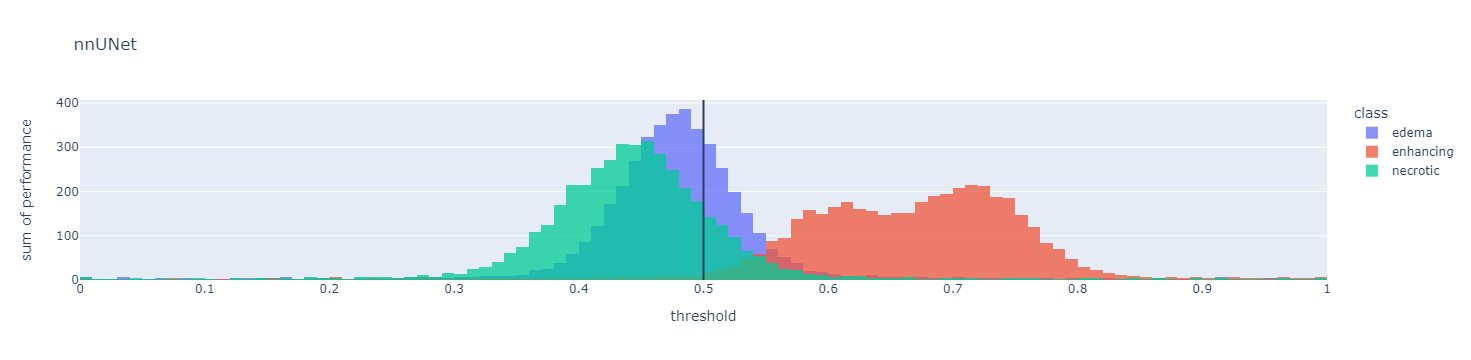

In [117]:
fig = px.histogram(df[df.model == "region"], x="threshold", y="performance", color="class", title="nnUNet")
fig.update_layout(barmode='overlay', xaxis=dict(tickmode = "linear", tick0 = 0.0, dtick = 0.1))
fig.update_traces(opacity=0.75)
fig.add_vline(x=0.5)
fig.show()

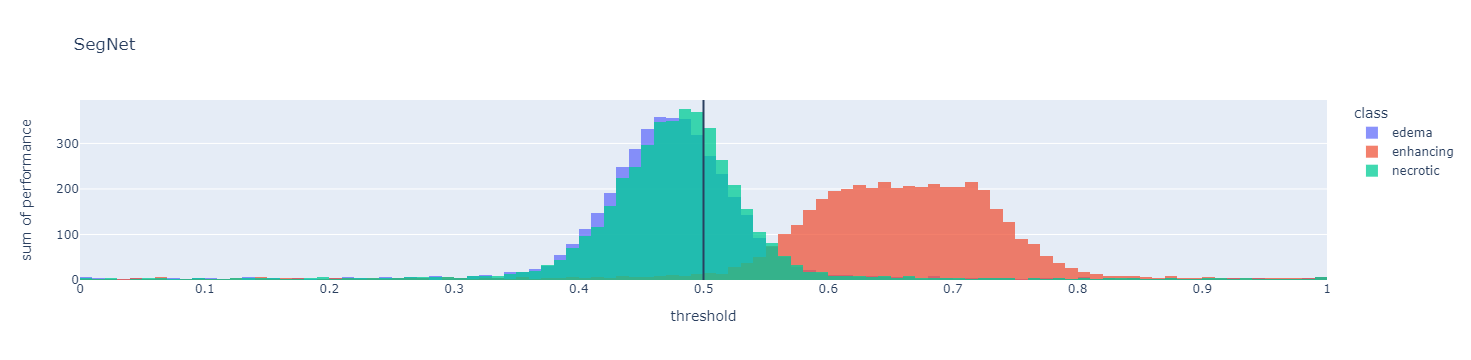

In [118]:
fig = px.histogram(df[df.model == "segnet"], x="threshold", y="performance", color="class", title="SegNet")
fig.update_layout(barmode='overlay', xaxis=dict(tickmode = "linear", tick0 = 0.0, dtick = 0.1))
fig.update_traces(opacity=0.75)
fig.add_vline(x=0.5)
fig.show()

## Best parameters

In [128]:
bp_df = defaultdict(list)

for path in tqdm(sorted(ls(database_path))):
    study = optuna.load_study(path.stem, f"sqlite:///{path}")
    
    model, fold = study.study_name.split("_")
    
    for c in ["edema", "enhancing", "necrotic"]:

        bp_df["model"].append(model)
        bp_df["fold"].append(fold)
        bp_df["class"].append(c)
        bp_df["parameter"].append(study.best_params[c])

bp_df = pd.DataFrame(bp_df)

100%|██████████| 10/10 [00:01<00:00,  5.22it/s]


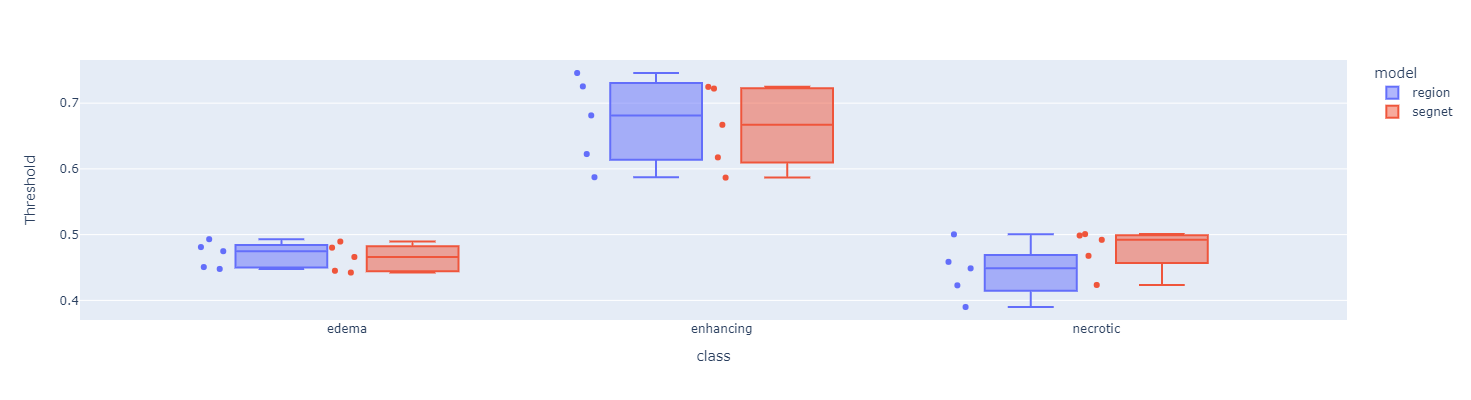

In [142]:
fig = px.box(bp_df, x="class", y="parameter", color="model", points="all", hover_data=["fold"], labels={"parameter": "Threshold"})
fig.update_layout(width=1000, height=400)

## Study detailed view

In [34]:
def optuna_slice_plot(study, **kwargs):
    fig = plot_slice(study)
    fig.update_layout(**kwargs)
    return fig

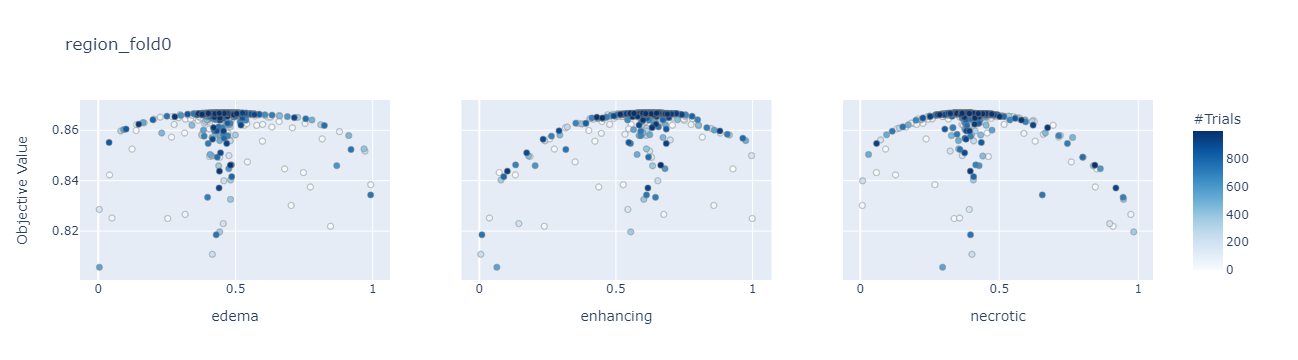

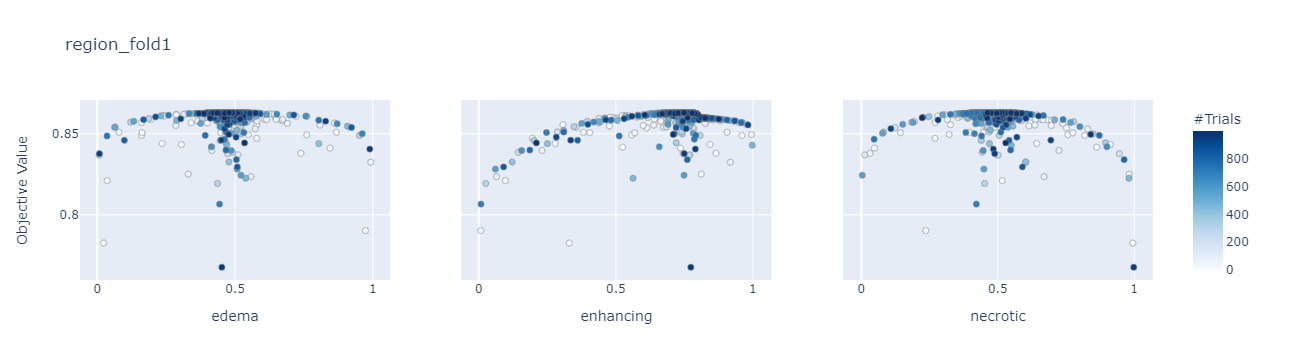

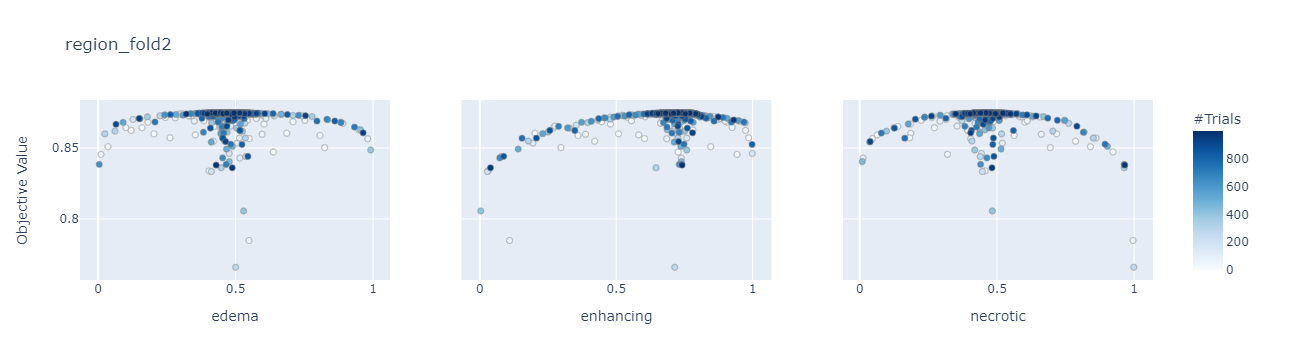

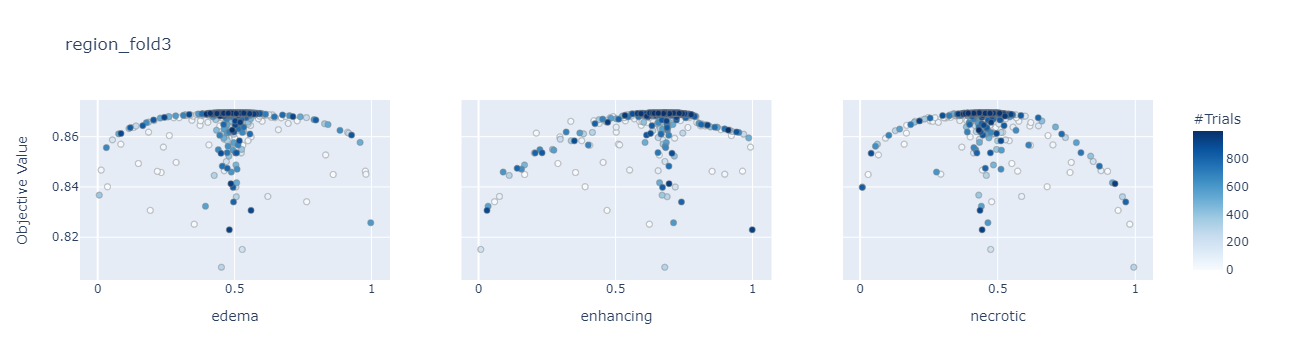

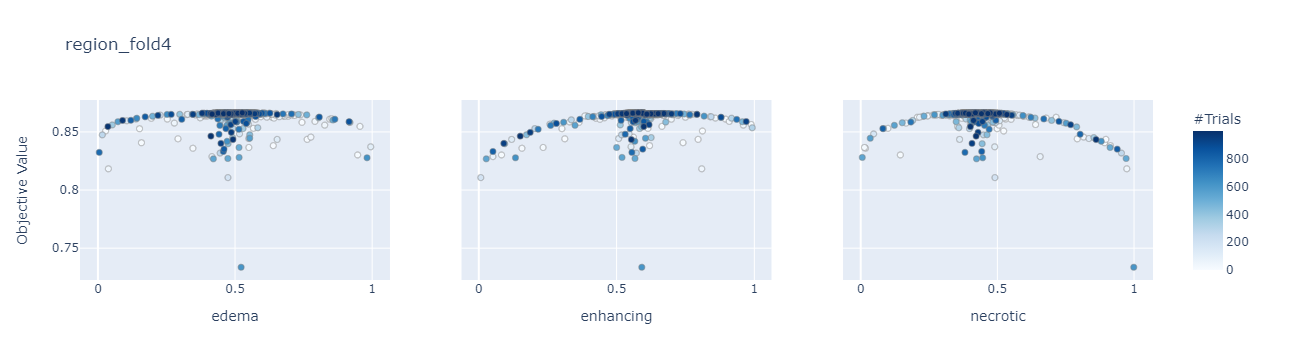

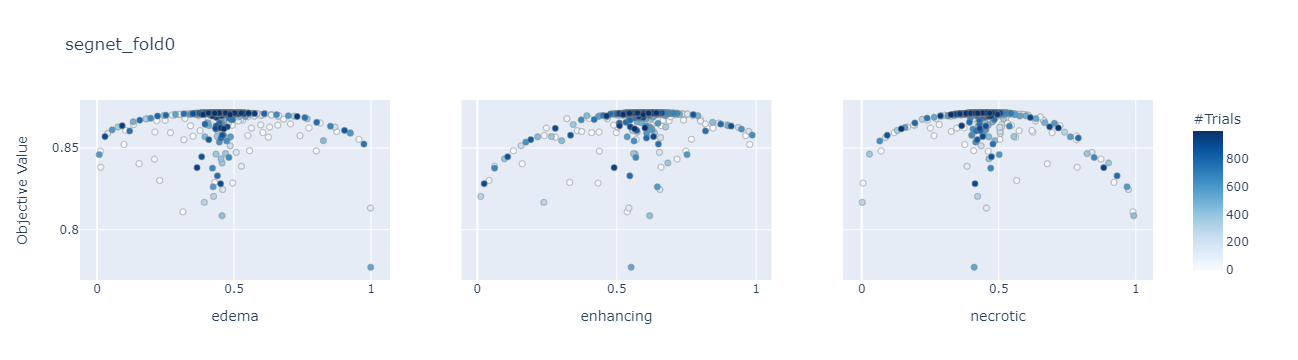

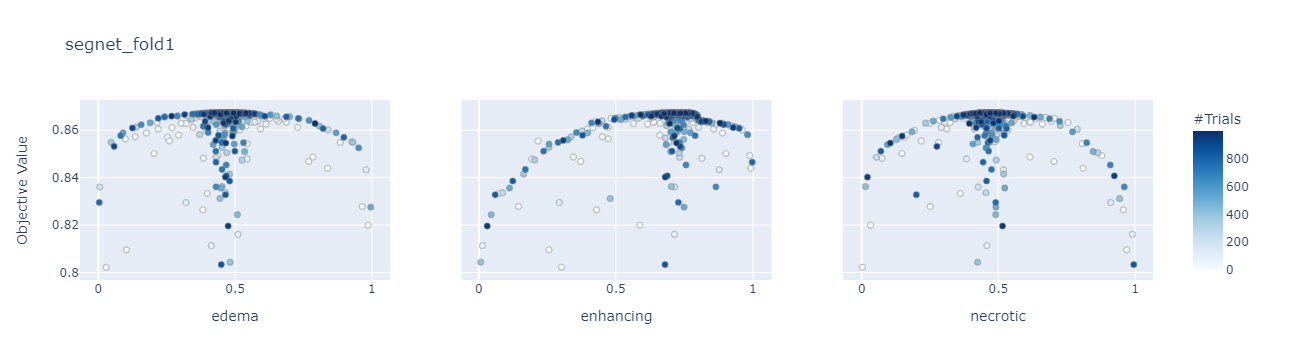

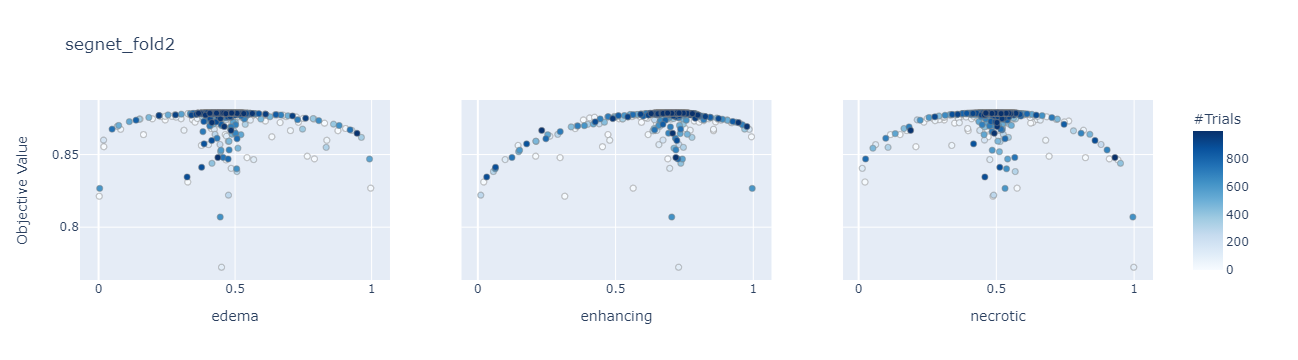

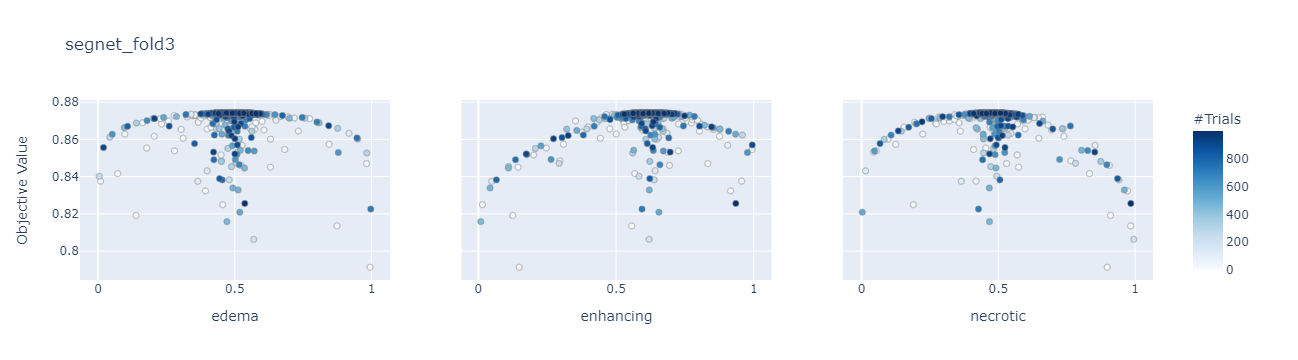

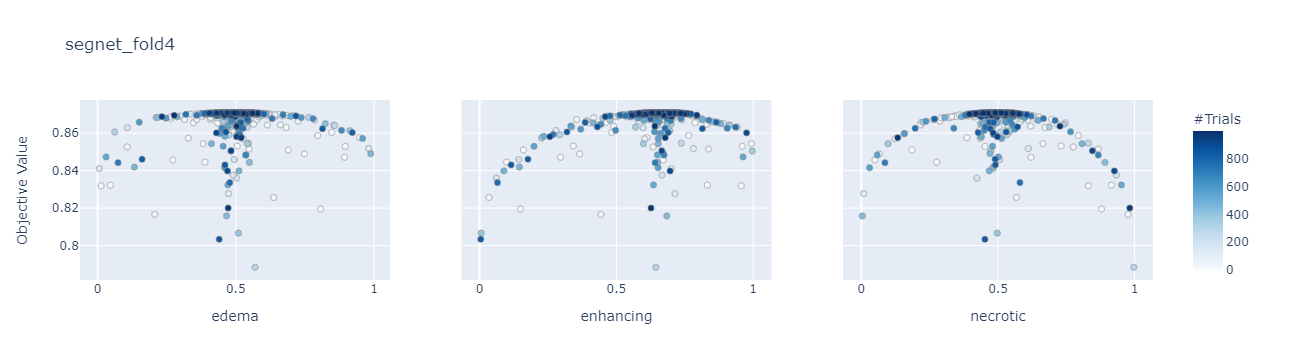

In [40]:
for path in sorted(ls(database_path)):
    study = optuna.load_study(path.stem, f"sqlite:///{path}")
    fig = optuna_slice_plot(study, title=path.stem)
    fig.show()